In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import backend as K
import GetLightcurves as gc

In [3]:

def dice_coeff(y_true, y_pred):
    smooth = 0.00001
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection +smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) +smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def weightFocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA): 
    w = tf.reduce_sum(targets,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 - w
    #w = 1 / (w  + 0.00001)
    #w = w**2
    w=tf.cast(w,tf.float32)   
    
    #inputs = K.flatten(inputs)
    #targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(w*K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    #w = 1 / (w  + 0.00001)
    w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def focal_dice_loss(y_true, y_pred):
    loss = FocalLoss(y_true, y_pred) + 1.5*dice_loss(y_true, y_pred)
    return loss

#print(weightFocalLoss(Ytest, np.ones((len(Ytest),4000,3),dtype='float32')))
#check score
def corr(y_true, y_pred):
    #wholesome thing.... lets see if this is any better
    corrects = 0 
    incorrects = 0
    cm=[[0,0],[0,0]]
    pred_arr=[]
    for i in range(0, len(y_true)):
        tmp=[0,0]
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        #newpl=np.asarray([1 if(el>np.mean(newpl)+np.std(newpl)) else 0 for el in newpl])
        #newfps=np.asarray([1 if(el>np.mean(newfps)+np.std(newfps)) else 0 for el in newfps])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]): 
                corrects+=1
                cm[0][0]+=1
                tmp[0]=1
            else: 
                incorrects+=1
                cm[1][0]+=1
                tmp[1]=1
            #print(val1[0,1], val2[0,1])
        #fps detect
        if(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                corrects+=1
                cm[1][1]+=1
                tmp[1]=1
            else: 
                cm[0][1]+=1
                incorrects+=1
                tmp[0]=1
            #print(val1[0,1], val2[0,1])
        pred_arr.append(tmp)
        #planet detection:
    
    print(corrects, incorrects)
    print(np.asarray(cm)/np.asarray(cm).sum())
    print(corrects/(corrects+incorrects))

def corrarr(y_true, y_pred):
    checkarr=[]
    for i in range(0, len(y_true)):
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]):
                checkarr.append(0)
            else: 
                checkarr.append(1)
            #print(val1[0,1], val2[0,1])
        #fps detect
        elif(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                checkarr.append(0)
            else: 
                checkarr.append(1)
    return(checkarr)

def split_by_snr(X, Y, thres):
    idscl=[i for i in range(0,len(X)) if(np.abs(np.mean(X[i])/np.std(X[i]))>thres)]
    idsns=[i for i in range(0,len(X)) if(np.abs(np.mean(X[i])/np.std(X[i]))<thres)]
    Xnoise=np.asarray([X[i] for i in idsns])
    Xcl=np.asarray([X[i] for i in idscl])
    Ynoise=np.asarray([Y[i] for i in idsns])
    Ycl=np.asarray([Y[i] for i in idscl])
    return(Xnoise, Xcl, Ynoise, Ycl)



def net_pred(train, convs):
    predspl=[]
    predsfps=[]
    predsbkg=[]
    for el in convs:
        pred=el.predict(train)
        predspl.append(pred[:,:,0])
        predsfps.append(pred[:,:,1])
        predsbkg.append(pred[:,:,2])
    pred
    pred_op=[]
    predspl=np.asarray(predspl)
    predsfps=np.asarray(predsfps)
    predsbkg=np.asarray(predsbkg)
    for i in range(0,len(train)):
        one1=np.max(predspl[:,i,:], axis=0).reshape(-1)
        one2=np.max(predsfps[:,i,:], axis=0).reshape(-1)
        one3=np.min(predsbkg[:,i,:], axis=0).reshape(-1)
        net=[[one1[i], one2[i],one3[i]] for i in range(0,len(one1))]
        pred_op.append(net)
    '''
    for i in range(0,len(train)):
        one=np.zeros((4000,3))
        for j in range(0,4000):
            one[j][0]=max(predspl[:,i,j])
            one[j][1]=max(predsfps[:,i,j])
            one[j][2]=min(predsbkg[:,i,j])
        pred_op.append(one)'''
    return(np.asarray(pred_op))

In [3]:
IMG_SIZE=4000
def build_model(imsz):
    conv_ip = keras.layers.Input(shape=(imsz,),name='Input')
    xi=keras.layers.Reshape((imsz, 1), input_shape=(imsz,),name='reshape_1')(conv_ip)
    #xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
    xi=keras.layers.BatchNormalization()(xi)

    x1=keras.layers.SeparableConv1D(16,kernel_size=3,activation='tanh',name='1st16_5')(xi)  #3998, 32
    c1=keras.layers.SeparableConv1D(16,kernel_size=3,strides=1,activation='tanh',name='2nd16_3')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1')(x2)  #1998, 64
    #x2=keras.layers.Conv1D(16,kernel_size=1,strides=2,name='maxpool_1')(x2)  #1998, 64
    x2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',name='1st32_5')(x2) #1996, 64
    c2=keras.layers.SeparableConv1D(32,kernel_size=5,strides=1,activation='tanh',name='2nd32_3')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2')(x3)  #996, 64
    #x3=keras.layers.Conv1D(32,kernel_size=1,strides=2,name='maxpool_2')(x3)  #996, 64
    x3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='1st64_5')(x3) #994, 128
    c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='2nd64_3')(x3) #992, 128

    x4=keras.layers.BatchNormalization(name='bn3')(c3)
    x4=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_3')(x4)  #496, 64
    #x4=keras.layers.Conv1D(64,kernel_size=1,strides=2,name='maxpool_3')(x4)  #496, 128
    x4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='1st128_5')(x4)  #494, 256
    c4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='2nd128_5')(x4) #492, 256


    x5=keras.layers.BatchNormalization(name='bn4')(c4) 
    x5=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_4')(x5) #246, 256 
    #x5=keras.layers.Conv1D(128,kernel_size=1,strides=2,name='maxpool_4')(x5)  #246, 256  
    x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='tanh',name='1st512_5')(x5)  #244, 256
    x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='tanh',name='2nd512_5')(x5)  #242, 256

    x5 = keras.layers.Conv1DTranspose(128, kernel_size=4, activation='relu', strides=2, name="T1st128_5")(x5)  #486, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', strides=1, name="T2nd128_5")(x5)  #490, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T3rd128_5")(x5)  #492, 256
    x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

    #c4 = keras.layers.Cropping1D((2,2))(c4) #488, 256
    x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
    x6 = keras.layers.Conv1DTranspose(128,kernel_size=3,strides=1,activation='relu',name='3rd128_3')(x6) #494, 256
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=4, activation='relu', strides=2, name="T1st64_3")(x6) #990, 128
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=1, name="T2nd64_3")(x6) #992, 128
    x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

    #c3 = keras.layers.Cropping1D((4,4))(c3) #984, 128
    x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
    x7 = keras.layers.Conv1DTranspose(64,kernel_size=3,strides=1,activation='relu',name='3rd64_3')(x7) #994, 128
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=4, activation='relu', strides=2, name="T1st32_3")(x7) #1990, 64
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', strides=1, name="T2nd32_3")(x7) #1992, 64
    x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

    x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
    x8 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=1,activation='relu',name='3rd32_3')(x8)  #1994, 64
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=4,strides=2,activation='relu',name='T1st16_3')(x8) #3990, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T2nd16_3')(x8) #3994, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='T4rth16_3')(x8) #3996, 32
    x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

    #c1 = keras.layers.Cropping1D((1,1))(c1) #3994, 32
    x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='3rd16_3')(x9) #3998, 32
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T3rd16_3')(x9) #4002, 32
    x9 = keras.layers.BatchNormalization(name='bn9')(x9)

    conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,name='semiop',activation='softmax')(x9) # (4000, 3)

    keras.backend.clear_session()
    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=focal_dice_loss ,metrics=[dice_coeff] )
    return(convNN)

In [29]:
IMG_SIZE=4000
def build_model2(imsz):
    conv_ip = keras.layers.Input(shape=(imsz,),name='Input')
    xi=keras.layers.Reshape((imsz, 1), input_shape=(imsz,),name='reshape_1')(conv_ip)

    x1=keras.layers.Conv1D(16,kernel_size=10,dilation_rate=3,activation='tanh',name='1st16_5', padding='same')(xi)  #3998, 32
    c1=keras.layers.Conv1D(16,kernel_size=5,activation='tanh',name='2nd16_3', padding='same')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1', padding='same')(x2)  #1998, 64
    x2=keras.layers.Conv1D(32,kernel_size=5,dilation_rate=2,strides=1,activation='tanh',name='1st32_5', padding='same')(x2) #1996, 64
    c2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',name='2nd32_3', padding='same')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2', padding='same')(x3)  #996, 64
    x3=keras.layers.Conv1D(64,kernel_size=5,dilation_rate=2,strides=1,activation='tanh',name='1st64_5', padding='same')(x3) #994, 128
    c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='2nd64_3', padding='same')(x3) #992, 128

    x4=keras.layers.BatchNormalization(name='bn3')(c3)
    x4=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_3', padding='same')(x4)  #496, 64
    x4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='1st128_5', padding='same')(x4)  #494, 256
    c4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='2nd128_5', padding='same')(x4) #492, 256

    x_5=keras.layers.BatchNormalization(name='bn4')(c4) 
    x_5=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_4', padding='same')(x_5) #246, 256 
    x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='1st512_5', padding='same')(x_5)  #244, 256
    x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='2nd512_5', padding='same')(x_5)  #242, 256
    #x_5=keras.layers.SeparableConv1D(256,kernel_size=3,strides=1,activation='tanh',name='3rd512_5', padding='same')(x_5)  #242, 256

    #tdepth, snr
    extra_ip = keras.layers.Input(shape=(2,),name='Input2')
    xi2=keras.layers.RepeatVector(250)(extra_ip)
    xi2 = keras.layers.Conv1D(256, 3, padding='same')(xi2)
    x5 = keras.layers.Multiply()([xi2, x_5])

    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=2, name="T1st128_5", padding='same')(x5)  #486, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T2nd128_5", padding='same')(x5)  #490, 256
    x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T3rd128_5", padding='same')(x5)  #492, 256
    x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

    x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
    x6 = keras.layers.Conv1DTranspose(128,kernel_size=3,strides=1,activation='relu',name='3rd128_3', padding='same')(x6) #494, 256
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=2, name="T1st64_3", padding='same')(x6) #990, 128
    x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=1, name="T2nd64_3", padding='same')(x6) #992, 128
    x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

    x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
    x7 = keras.layers.Conv1DTranspose(64,kernel_size=3,strides=1,activation='relu',name='3rd64_3', padding='same')(x7) #994, 128
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', strides=2, name="T1st32_3", padding='same')(x7) #1990, 64
    x7 = keras.layers.Conv1DTranspose(32, kernel_size=5, activation='relu', strides=1, name="T2nd32_3", padding='same')(x7) #1992, 64
    x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

    x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
    x8 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=1,activation='relu',name='3rd32_3', padding='same')(x8)  #1994, 64
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=2,activation='relu',name='T1st16_3', padding='same')(x8) #3990, 32
    x8 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T2nd16_3', padding='same')(x8) #3994, 32
    x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

    #c1 = keras.layers.Cropping1D((1,1))(c1) #3994, 32
    x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='3rd16_3', padding='same')(x9) #3998, 32
    x9 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T3rd16_3', padding='same')(x9) #4002, 32
    x9 = keras.layers.BatchNormalization(name='bn9')(x9)

    conv_op = keras.layers.Conv1D(2,kernel_size=1,strides=1,name='semiop',activation='sigmoid', padding='same')(x9) # (4000, 3)

    keras.backend.clear_session()
    convNN = keras.Model(inputs=[conv_ip,extra_ip], outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=focal_dice_loss ,metrics=[generalized_dice_coeff] )
    return(convNN)



In [5]:
#import data
CV_PATH='../../training_data/cross_validation/'
MN_PATH='../../training_data/'
'''Xtrain1, Ytrain1, Ctrain1, TrainID1 = gc.read_tfr_record(CV_PATH+'zero_aug__s0',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtrain2, Ytrain2, Ctrain2, TrainID2 = gc.read_tfr_record(CV_PATH+'zero_aug__s1',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtrain3, Ytrain3, Ctrain3, TrainID3 = gc.read_tfr_record(CV_PATH+'zero_aug__s2',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtrain4, Ytrain4, Ctrain4, TrainID4 = gc.read_tfr_record(CV_PATH+'zero_aug__s3',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtest, Ytest, Ctest, TestID = gc.read_tfr_record(CV_PATH+'zero_aug__test',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

sm_wt1=np.loadtxt(CV_PATH+'samps0.csv', delimiter=" " )
sm_wt2=np.loadtxt(CV_PATH+'samps1.csv', delimiter=" " )
sm_wt3=np.loadtxt(CV_PATH+'samps2.csv', delimiter=" " )
sm_wt4=np.loadtxt(CV_PATH+'samps3.csv', delimiter=" " )'''
Xtrain, Ytrain, Ctrain, TrainID = gc.read_tfr_record(MN_PATH+'sem_seg_av_zer_aug_train',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtest, Ytest, Ctest, TestID = gc.read_tfr_record(MN_PATH+'sem_seg_av_zer_aug_test',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

In [5]:
#filter: make residue network... see if this is any better... get all networks together?
'''Xtrainf1 = np.asarray([Xtrain1[i] for i in range(0,len(Xtrain1)) if (sm_wt1[i])])
Ytrainf1 = np.asarray([Ytrain1[i] for i in range(0,len(Xtrain1)) if (sm_wt1[i])])
Xtrainf2 = np.asarray([Xtrain2[i] for i in range(0,len(Xtrain2)) if (sm_wt2[i])])
Ytrainf2 = np.asarray([Ytrain2[i] for i in range(0,len(Xtrain2)) if (sm_wt2[i])])
Xtrainf3 = np.asarray([Xtrain3[i] for i in range(0,len(Xtrain3)) if (sm_wt3[i])])
Ytrainf3 = np.asarray([Ytrain3[i] for i in range(0,len(Xtrain3)) if (sm_wt3[i])])
Xtrainf4 = np.asarray([Xtrain4[i] for i in range(0,len(Xtrain4)) if (sm_wt4[i])])
Ytrainf4 = np.asarray([Ytrain4[i] for i in range(0,len(Xtrain4)) if (sm_wt4[i])])

Xtrain = np.concatenate([Xtrainf1, Xtrainf2, Xtrainf3, Xtrainf4])
Ytrain = np.concatenate([Ytrainf1, Ytrainf2, Ytrainf3, Ytrainf4])'''

'Xtrainf2 = np.asarray([Xtrain2[i] for i in range(0,len(Xtrain2)) if (sm_wt2[i])])\nYtrainf2 = np.asarray([Ytrain2[i] for i in range(0,len(Xtrain2)) if (sm_wt2[i])])\nXtrainf3 = np.asarray([Xtrain3[i] for i in range(0,len(Xtrain3)) if (sm_wt3[i])])\nYtrainf3 = np.asarray([Ytrain3[i] for i in range(0,len(Xtrain3)) if (sm_wt3[i])])\nXtrainf4 = np.asarray([Xtrain4[i] for i in range(0,len(Xtrain4)) if (sm_wt4[i])])\nYtrainf4 = np.asarray([Ytrain4[i] for i in range(0,len(Xtrain4)) if (sm_wt4[i])])\n\nXtrain = np.concatenate([Xtrainf1, Xtrainf2, Xtrainf3, Xtrainf4])\nYtrain = np.concatenate([Ytrainf1, Ytrainf2, Ytrainf3, Ytrainf4])'

In [16]:
min_tr=np.asarray([[min(row),np.abs(np.mean(row)/np.std(row))] for row in Xtrain])
min_test=np.asarray([[min(row),np.abs(np.mean(row)/np.std(row))] for row in Xtest])
min_tr=1/(1+np.exp(-5*min_tr))
min_test=1/(1+np.exp(-5*min_test))
print(min_tr.shape)

(7328, 2)


In [17]:
print(min(min_test[:,0]),max(min_test[:,0]))
print((min_test[:,0]>0.499).sum())

0.00073815417 0.49979708
447


In [18]:
Ytrain=np.asarray(Ytrain,dtype = 'float32').reshape(len(Xtrain),4000,3)
Ytest=np.asarray(Ytest,dtype = 'float32').reshape(len(Xtest),4000,3)
Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtest=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
#Xtrainf=np.asarray([0.5*(np.tanh(0.1*(row - np.median(row))/np.std(row))) for row in Xtrain])
#Xtestf=np.asarray([0.5*(np.tanh(0.1*(row - np.median(row))/np.std(row))) for row in Xtest])
print(Ytrain.shape, Xtrain.shape)

(7328, 4000, 3) (7328, 4000)


In [46]:
mn = []
sr =[]
for el in Xtrain:
    mn.append(np.mean(el))
    sr.append(np.std(el))

    #print(np.mean(el),np.std(el))
sr=np.asarray(sr)
mn=np.asarray(mn)
print(max(mn),min(mn))
print(max(np.abs(mn/sr)),min(np.abs(mn/sr)))
print(np.median(np.asarray(sr)))
print((mn>0.25).sum()/len(sr))

0.40307197 -0.121604264
0.51356566 3.9812167e-07
0.2319205
0.0005458515283842794


In [29]:
#get train test splits
X_trN, X_trC, Y_trN,  Y_trC = split_by_snr(Xtrain, Ytrain, 0.015)
X_testN, X_testC, Y_testN,  Y_testC = split_by_snr(Xtest, Ytest, 0.015)
print(X_trN.shape, Y_trN.shape, X_trC.shape, Y_trC.shape)
print(X_testN.shape, Y_testN.shape, X_testC.shape, Y_testC.shape)

(3025, 4000) (3025, 4000, 3) (4303, 4000) (4303, 4000, 3)
(749, 4000) (749, 4000, 3) (1084, 4000) (1084, 4000, 3)


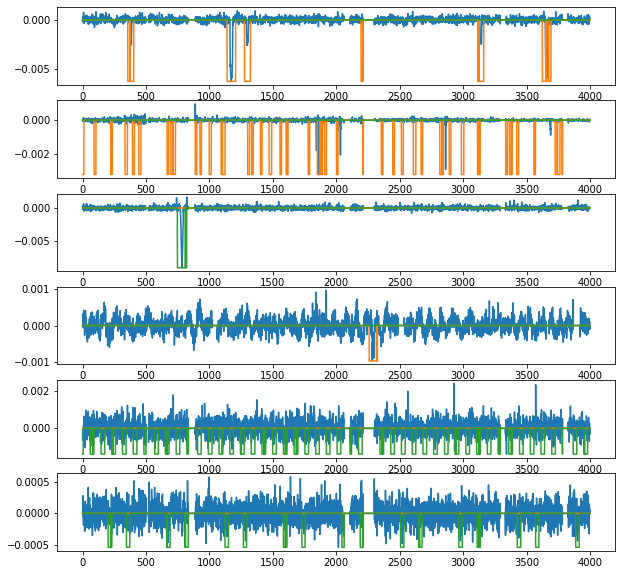

In [11]:
fig, ax = plt.subplots(6,1, figsize=(10,10))
for i in range(6):
    n= Ytrainf1[i+90].reshape(4000,3)
    m=min(Xtrainf1[i+90])
    ax[i].plot(Xtrainf1[i+90])
    ax[i].plot(n[:,0]*m)
    ax[i].plot(n[:,1]*m)

In [7]:
cnt=[1 for el in Y_testN if(np.any(el[:,0]>0))]
print(np.asarray(cnt).sum())

NameError: name 'Y_testN' is not defined

In [42]:
X_valf, X_testf, Y_valf, Y_testf = train_test_split(Xtest, Ytest, test_size=0.5, shuffle=True)
print(X_testf.shape, X_valf.shape)

(917, 4000) (916, 4000)


0.30146548
0.2585484
0.2847997
0.29351595


<function matplotlib.pyplot.show(close=None, block=None)>

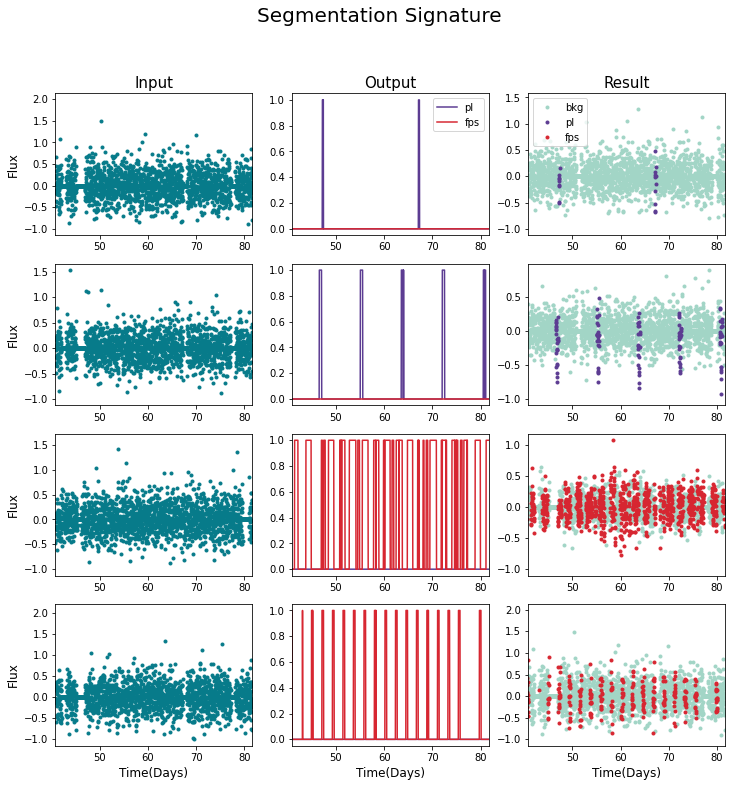

In [25]:


#vararr=np.random.randint(0,len(Xtrain),size=10)
#vararr=[5,247,3,375]
#vararr=[375,376,396,442,456,613]
vararr=[0,1,2,3,4]
fig,ax=plt.subplots(4,3,figsize=(12,12))
j=0

xaxis = np.arange(0,4000,1)*29.5/1440
plt.suptitle('Segmentation Signature',size=20)
ax[0][0].set_title('Input',size=15)
ax[0][1].set_title('Output',size=15)
ax[0][2].set_title('Result',size=15)

ax[3][0].set_xlabel('Time(Days)',size=12)
ax[3][1].set_xlabel('Time(Days)',size=12)
ax[3][2].set_xlabel('Time(Days)',size=12)
for i in range(0,4):
    print(np.std(X_trC[vararr[i]]))
    ax[i][0].plot(np.arange(0,4000,1)*29.4/1440,X_trC[vararr[i]],color='#077b8a',marker='.',ls='None')
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in Ytrain[vararr[i]]])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    #predpl = np.where(Ytest[ar[i],:,0]==1)[0]
    bkg=np.where(counts==2)[0]
    ax[i][0].set_ylabel('Flux',size=12)
    ax[i][2].plot(bkg*29.4/1440,Xtrain[vararr[i]][bkg],marker='.',ls='None',color='#a2d5c6',label='bkg')
    ax[i][2].plot(pl*29.4/1440,Xtrain[vararr[i]][pl],marker='.',ls='None',color='#5c3c92',label='pl')
    ax[i][2].plot(fps*29.4/1440,Xtrain[vararr[i]][fps],marker='.',ls='None',color='#d72631',label='fps')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,0],color='#5c3c92',label='pl')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,1],color='#d72631',label='fps')
    ax[0][1].legend()
    ax[0][2].legend()
    ax[i][2].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][1].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][0].set_xlim(2000*29.4/1440,4000*29.4/1440)
#plt.savefig('fprez_segmentation2')
plt.show

In [30]:
convNN2=build_model2(4000)
#convNN2.load_weights(MN_PATH+'diltest.h5')

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
1st16_5 (Conv1D)                (None, 4000, 16)     176         reshape_1[0][0]                  
__________________________________________________________________________________________________
2nd16_3 (Conv1D)                (None, 4000, 16)     1296        1st16_5[0][0]                    
___________________________________________________________________________________

In [40]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
#history=convNN2.fit(np.asarray(Xtrain),np.asarray(Ytrain), batch_size=16, epochs=10 , verbose=1, sample_weight=10*sm_wt,
#     validation_data=(X_valf, Y_valf), callbacks=[es_callback])  
history=convNN2.fit([np.asarray(Xtrain),min_tr],np.asarray(Ytrain[:,:,0:2]), batch_size=16, epochs=2, verbose=1,
     validation_data=([Xtest,min_test], Ytest[:,:,0:2]))  

Epoch 1/2
458/458 [==============================] - 199s 435ms/step - loss: 1.0924 - generalized_dice_coeff: 0.7345 - val_loss: 1.1324 - val_generalized_dice_coeff: 0.7475
Epoch 2/2
458/458 [==============================] - 198s 433ms/step - loss: 1.0825 - generalized_dice_coeff: 0.7307 - val_loss: 1.1277 - val_generalized_dice_coeff: 0.7533


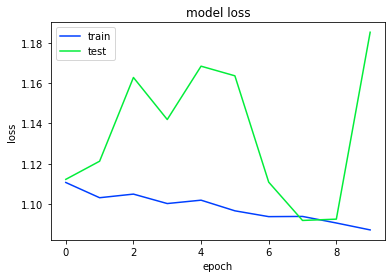

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('fprez_segment.png')
plt.show()

In [41]:
pred_op=convNN2.predict([np.array(Xtest),min_test])
#pred_optr=convNN2.predict([np.array(Xtrain),min_tr])

Text(0.5, 0, 'Phase')

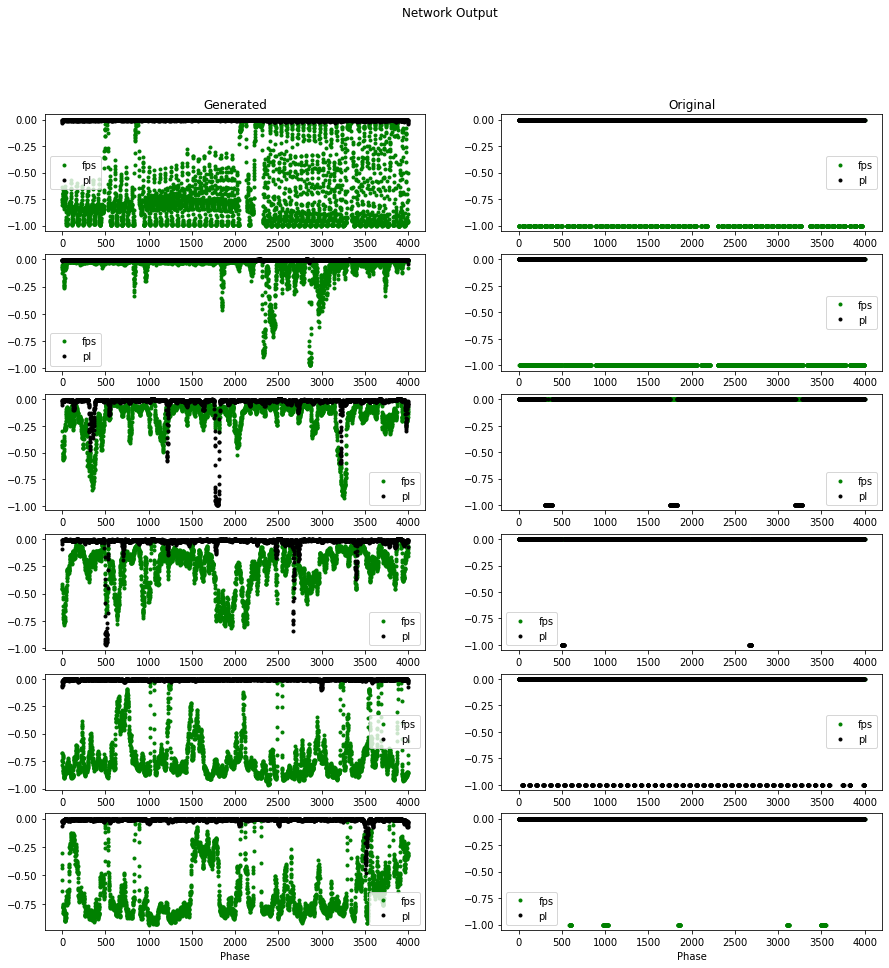

In [43]:

#X_testf = np.asarray(X_testf)

fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
ar=np.random.randint(len(Xtest),size=10)
#ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    #m = min(Xtestf)
    #ax[i][0].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='gray',ls='None',marker='.',label='pl')

    #ax[i][1].plot(Xtest[ar[i],:],color='gray',ls='None',marker='.',label='data')
    #ax[i][1].plot(-Ytest[ar[i],:,1],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    ax[i][0].legend('flux')
    #ax[i][0].set_ylim(-1.05,0.1)
    #ax[i][1].set_ylim(-1.05,0.1)
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')

#plt.savefig('present_itsamust')


In [37]:
convNN2.save(MN_PATH+'diltest_ub.h5')
#convNN2.save_weights(MN_PATH+'diltest_w.h5')

C:\Program Files\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [44]:
corr(Ytest, pred_op)
#corr(Ytrain, pred_optr)

1475 378
[[0.47544522 0.1154884 ]
 [0.08850513 0.32056125]]
0.7960064759848894


In [14]:
samp_tr=corrarr(Ytrain, pred_optr)
samp_test=corrarr(Ytest, pred_op)

In [48]:
#net ensemble
#convNN5= keras.models.load_model(CV_PATH+'s0.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
#convNN6= keras.models.load_model(CV_PATH+'s1.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
#convNN7= keras.models.load_model(CV_PATH+'s2.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
#convNN8= keras.models.load_model(CV_PATH+'s3.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
convNN1= keras.models.load_model(CV_PATH+'s0_2.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
convNN2= keras.models.load_model(CV_PATH+'s1_2.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
convNN3= keras.models.load_model(CV_PATH+'s2_2.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
convNN4= keras.models.load_model(CV_PATH+'s3_2.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})
convNN5= keras.models.load_model(CV_PATH+'sm1_3.h5',custom_objects={'focal_dice_loss': focal_dice_loss,'dice_coeff':dice_coeff})

In [11]:
pred1=convNN1.predict(Xtest)
pred2=convNN2.predict(Xtest)
pred3=convNN3.predict(Xtest)
pred4=convNN4.predict(Xtest)

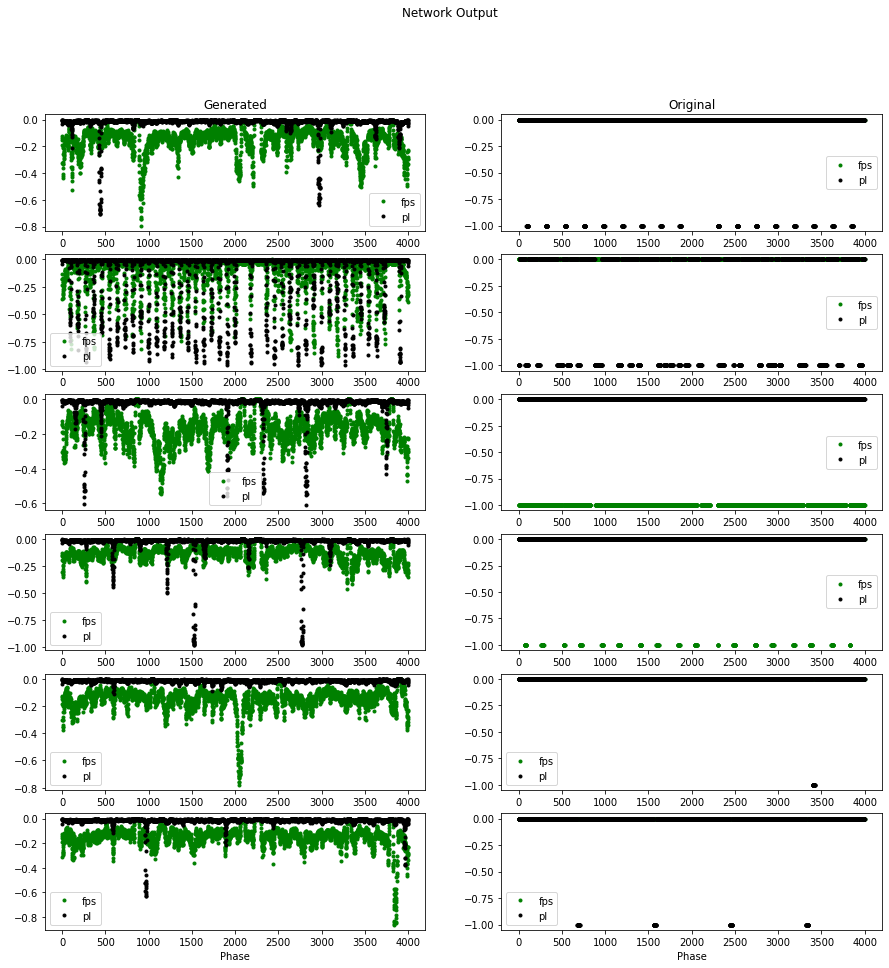

In [38]:
pred_op=np.asarray(pred_op)
fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
#ar=np.random.randint(len(Xtest),size=10)
ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][0].legend('flux')
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')
plt.show()
#plt.savefig('present_itsamust')


In [56]:
pred_op=net_pred(Xtest,[convNN1, convNN2, convNN3, convNN4])


In [57]:
out= corrarr(Ytest, pred_op)
print(np.asarray(out).shape)
print(np.asarray(out).sum())

(1833,)
351


In [58]:
Xtestf = np.asarray([Xtest[i] for i in range(0,len(Xtest)) if (out[i])])
Ytestf = np.asarray([Ytest[i] for i in range(0,len(Xtest)) if (out[i])])

In [59]:
pred_op2=convNN5.predict(Xtestf)
out2= corrarr(Ytestf, pred_op2)
print(np.asarray(out2).shape)
print(np.asarray(out2).sum())

(351,)
92


In [55]:
corr(Ytest,pred_op)

1470 386
[[0.46767241 0.11206897]
 [0.09590517 0.32435345]]
0.7920258620689655


In [16]:
val=dice_coeff(Ytest,np.around(np.asarray(pred_op,dtype='float32')))
print(val.numpy())

0.78573513


In [17]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(np.around(Ytest), np.around(pred_op))
m.result().numpy()

0.72818613

In [40]:
netsamps=[]
for x in range(4):
    Xtrain, Ytrain, Ctrain, TrainID = gc.read_tfr_record(CV_PATH+'zero_aug__s'+str(x),
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])
    Ytrain=np.asarray(Ytrain,dtype = 'float32').reshape(len(Xtrain),4000,3)
    Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
    print('import')
    op=net_pred(Xtrain,[convNN1, convNN2, convNN3, convNN4])
    #samps=[] 
    samps=corrarr(Ytrain, op)
    '''
    for i in range(0,len(Xtrain)):
        val=(dice_coeff(Ytrain[i,:,0:2],np.around(np.asarray(op[i,:,0:2],dtype='float32')))).numpy()
        samps.append(1-val)
    #print(samps)'''
    netsamps.append(samps)

    

import
import
import
import


In [41]:
print(np.asarray(netsamps[1]).shape)
for i in range(0,4):
    np.savetxt(CV_PATH+'samps'+str(i)+'.csv',netsamps[i],delimiter=" ")

(1833,)


In [19]:
def classifier():
    conv_ip = keras.layers.Input(shape=(4000,),name='Input')
    xi=keras.layers.Reshape((4000, 1), input_shape=(4000,2),name='reshape_1')(conv_ip)
    
    x1=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',name='1st16_5')(xi)  #3998, 32
    c1=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',name='2nd16_3')(x1)  #3996, 32

    x2=keras.layers.BatchNormalization(name='bn1')(c1)
    x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1')(x2)  #1998, 64
    x2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',name='1st32_5')(x2) #1996, 64
    c2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',name='2nd32_3')(x2) #1992, 64

    x3=keras.layers.BatchNormalization(name='bn2')(c2) 
    x3=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_2')(x3)  #996, 64
    x3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',name='1st64_5')(x3) #994, 128
    c3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',name='2nd64_3')(x3) #992, 128


    x5=keras.layers.Flatten(name='flat_1')(c3)
    x5=keras.layers.Dense(64,activation='relu')(x5)
    x5=keras.layers.Dense(64,activation='relu')(x5)
    x5=keras.layers.Dense(64,activation='relu')(x5)
    conv_op=keras.layers.Dense(1, activation='sigmoid')(x5)

    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='bce' ,metrics=['accuracy'] )
    return(convNN)   

In [11]:
tr_ac=[]
for el in Ytrain:
    prop1 = np.asarray(el[:,0]).sum()
    prop2 = np.asarray(el[:,1]).sum()
    if(prop1>prop2): tr_ac.append(0)
    else: tr_ac.append(1)

tst_ac=[]
for el in Ytest:
    prop1 = np.asarray(el[:,0]).sum()
    prop2 = np.asarray(el[:,1]).sum()
    if(prop1>prop2): tst_ac.append(0)
    else: tst_ac.append(1)

print(np.array(tr_ac).shape, np.array(tst_ac).shape)


(7328,) (1833,)


In [47]:
clsf = classifier()

Model: "Convolutional_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 4000)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4000, 1)           0         
_________________________________________________________________
1st16_5 (Conv1D)             (None, 3998, 16)          64        
_________________________________________________________________
2nd16_3 (Conv1D)             (None, 3996, 16)          784       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3996, 16)          64        
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1998, 16)          0         
_________________________________________________________________
1st32_5 (Conv1D)             (None, 1996, 32)     

In [48]:
hist = clsf.fit(np.asarray(Xtrain),np.asarray(samp_tr), batch_size=64, epochs=4, verbose=1,
     validation_data=(np.asarray(Xtest), np.asarray(samp_test)))

Epoch 1/4
115/115 [==============================] - 37s 312ms/step - loss: 0.5043 - accuracy: 0.7968 - val_loss: 0.5528 - val_accuracy: 0.8052
Epoch 2/4
115/115 [==============================] - 36s 309ms/step - loss: 0.4720 - accuracy: 0.8023 - val_loss: 0.5113 - val_accuracy: 0.8052
Epoch 3/4
115/115 [==============================] - 36s 309ms/step - loss: 0.4470 - accuracy: 0.8025 - val_loss: 0.4917 - val_accuracy: 0.8052
Epoch 4/4
115/115 [==============================] - 36s 309ms/step - loss: 0.4212 - accuracy: 0.8054 - val_loss: 0.4920 - val_accuracy: 0.8041


In [49]:
val=clsf.predict(Xtest)


In [50]:
cm=confusion_matrix( samp_test, np.asarray(val>0.4))
print(cm)

[[1418   58]
 [ 336   21]]


In [67]:
print(min(min_test[:,0]),max(min_test[:,0]))
print(len([1 for i in range(0,len(samp_test)) if min_test[i,1]<0.51]))
len([print(min_test[i]) for i in range(0,len(samp_test)) if samp_test[i] and min_test[i,1]<0.51])

0.19121666 0.4999594
1488
[0.4993549 0.5058441]
[0.49938196 0.50068235]
[0.49969053 0.50710464]
[0.49980554 0.50677437]
[0.49981797 0.5064621 ]
[0.4998727  0.50122815]
[0.49956504 0.50001633]
[0.49902445 0.5092182 ]
[0.499826   0.50200135]
[0.49951017 0.50910324]
[0.49960253 0.507734  ]
[0.49975824 0.50008893]
[0.49961323 0.50160336]
[0.49728116 0.5092614 ]
[0.49920958 0.50633335]
[0.49982053 0.50034124]
[0.49861756 0.5015705 ]
[0.4992687 0.502608 ]
[0.49955216 0.50436586]
[0.49983    0.50389355]
[0.49939835 0.5018385 ]
[0.4998015 0.5011549]
[0.4993497 0.5016326]
[0.4996491  0.50341016]
[0.49974513 0.5052665 ]
[0.49961728 0.5048944 ]
[0.49989662 0.50380105]
[0.49936137 0.5052652 ]
[0.49963012 0.5086555 ]
[0.4995242  0.50363135]
[0.4997954  0.50145215]
[0.49985632 0.50669605]
[0.49984032 0.50053495]
[0.49974847 0.50632143]
[0.49975038 0.50647026]
[0.46874416 0.5089083 ]
[0.49953812 0.5006482 ]
[0.4997043  0.50283515]
[0.49989882 0.50074524]
[0.49982935 0.50506026]
[0.49971965 0.50415814

296